## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], regularizers=None):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regularizers)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regularizers)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for l1, l2 in zip(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = {0},{1}".format(l1,l2))
    model = build_mlp(input_shape=x_train.shape[1:], regularizers=l1_l2(l1,l2))
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-{0}-l2-{1}".format(l1,l2)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.01,0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 62us/step - loss: 5.6914 - acc: 0.3423 - val_loss: 5.2352 - val_acc: 0.3957
Epoch 2/50
50000/50000 [==============================] - 3s 50us/step - loss: 4.8266 - acc: 0.4278 - val_loss: 4.5141 - val_acc: 0.4229
Epoch 3/50
50000/50000 [==============================] - 2s 50us/step - loss: 4.1675 - acc: 0.4539 - val_loss: 3.9350 - val_acc: 0.4511
Epoch 4/50
50000/50000 [==============================] - 2s 48us/step - loss: 3.6189 - acc: 0.4718 - val_loss: 3.5381 - val_acc: 0.4153
Epoch 5/50
50000/50000 [==============================] - 2s 48us/step - loss: 3.1707 - acc: 0.4800 - val_loss: 3.1602 - val_acc: 0.4199
Epoch 6/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.8010 - acc: 0.4847 - val_loss: 2.7162 - val_acc: 0.4669
Epoch 7/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.5047 - acc: 0.4913 - val_loss: 2.5760 - val_acc

50000/50000 [==============================] - 2s 47us/step - loss: 1.5964 - acc: 0.4351 - val_loss: 1.6108 - val_acc: 0.4197
Epoch 3/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.5077 - acc: 0.4670 - val_loss: 1.4962 - val_acc: 0.4673
Epoch 4/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.4491 - acc: 0.4839 - val_loss: 1.5060 - val_acc: 0.4644
Epoch 5/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.3999 - acc: 0.5027 - val_loss: 1.4071 - val_acc: 0.5043
Epoch 6/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3544 - acc: 0.5187 - val_loss: 1.5323 - val_acc: 0.4643
Epoch 7/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.3230 - acc: 0.5287 - val_loss: 1.4014 - val_acc: 0.5098
Epoch 8/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2946 - acc: 0.5396 - val_loss: 1.4079 - val_acc: 0.5020
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 2s 48us/step - loss: 1.5204 - acc: 0.4591 - val_loss: 1.5538 - val_acc: 0.4439
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.4573 - acc: 0.4817 - val_loss: 1.4886 - val_acc: 0.4696
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.3974 - acc: 0.5024 - val_loss: 1.4899 - val_acc: 0.4646
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3629 - acc: 0.5158 - val_loss: 1.4572 - val_acc: 0.4845
Epoch 7/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3314 - acc: 0.5270 - val_loss: 1.4037 - val_acc: 0.5014
Epoch 8/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.2958 - acc: 0.5372 - val_loss: 1.4454 - val_acc: 0.4989
Epoch 9/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2582 - acc: 0.5551 - val_loss: 1.4491 - val_acc: 0.4913
Epoch 10/50
50000/50000 [===========================

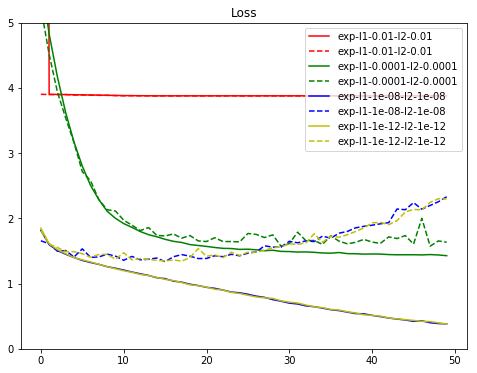

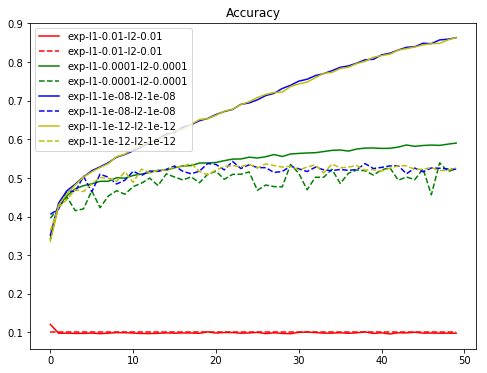

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()